# TaRGET Project CC ATAC-seq Data Inspection

__Author:__ Bryan Quach  
__Date:__ March 25, 2017

## Objective

### Estimated Analysis Time: <1 day*

Chromatin accessibility profiles are expected to be more similar within tissues than across tissues. Using 50 base pair paired-end ATAC-seq data from the TaRGET project Collaborative Cross (CC) mice, we set out to evaluate this assumption. If we apply PCA and/or cluster analyis to the data, we hypothesize that chromatin accessibility profiles for samples from the same tissue will group together. Our objective is to test this hypothesis as well as visually assess how notable the batch effects are between data that were sequenced on different dates. All of our data were sequenced by the UNC High-Throughput Sequencing Facility (HTSF).

**This estimate optimistically assumes that the analysis will be done as shown below without interruption, with an internet connection with high speed data transfer rates, and with all necessary software already installed. Limitations in internet data transfer rates and software installation can significantly increase analysis time.*

## Analysis Outline

The analysis can be roughly divided into the following steps:

* Count matrix generation and normalization
* Exploratory Data Analysis (PCA)

## R Packages

In addition to the base packages, we use the following R packages in this analysis:

* [DESeq2](http://www.bioconductor.org/packages/release/bioc/html/DESeq2.html)
* [dbscan](https://cran.r-project.org/web/packages/dbscan/index.html)


## Count matrix generation and normalization

The data we are working with has already been processed into the form of a count matrix with rows containing chromatin regions and columns containing sample identifiers. This matrix contains data for all tissues and conditions. Since we are doing multiple PCA analyses, we will be creating and normalizing several submatrices that will be used to eventually investigate the following:

* Are all the samples grouping by tissue based on chromatin accessibility profiles?
* Do we see a difference within tissue between exposure groups based on chromatin accessibility profiles?

The reason for multiple matrices is that we want to normalize the subsets of the data independently for each of the analyses in case a subset of samples unrelated to a particular analysis has an overpowering effect on the normalization. Because the dataset we start with is large, we will do the normalizations on the UNC Longleaf compute cluster.

We start with a count matrix that we put through a filtering process to remove the rows that have no or nearly no information about the level of chromatin accessibility. As a simple filtering we apply the following rule: removing rows of the `DESeqDataSet` that have 10 or less counts across all samples. This filtering helps to reduce the contribution of extremely lowly expressed or uninformative regions to the results of PCA.

The data transformation we apply is a [variance-stabilizing transformation](https://en.wikipedia.org/wiki/Variance-stabilizing_transformation) implemented with the DESeq2 `vst` function. It uses a subset of the regions instead of the full set to provide computational speed-ups. We specify that 10000 regions be used to estimate the appropriate transformation function. Once the transformations complete, we save the transformed count matrices to an Rdata file.

In [ ]:
#Do this on the local machine terminal
scp data/atac_regions_count_matrix.txt bquach@longleaf.unc.edu:/pine/scr/b/q/bquach/cc_atac_normalization/
scp scripts/normalize.R bquach@longleaf.unc.edu:/pine/scr/b/q/bquach/cc_atac_normalization/

#Do this on Longleaf
cd /pine/scr/b/q/bquach/cc_atac_normalization/
sbatch --mem=48G --time=2:00:00 -o normalize.out -n 1 --wrap="Rscript normalize.R"

## Principal Component Analysis and Clustering

We will generate several PCA plots to visually explore several different questions we have about the data. As a reminder, these questions are:

* Are all the samples grouping by tissue based on chromatin accessibility profiles?
* Do we see a difference within tissue between exposure groups based on chromatin accessibility profiles?

To visually explore each of these questions, we will assign geometric or color labels to aid in the comparison of groups. Because the PCA analyses are on a large set of regions, we run all of them on the UNC compute cluster Longleaf and save the PCA results as R data objects.

In [ ]:
#Do this on Longleaf
cd /pine/scr/b/q/bquach/cc_atac_normalization/
sbatch --mem=48G --time=4:00:00 -o pca.out -n 1 --wrap="Rscript pca.R"

#Do this on local machine
scp bquach@longleaf.unc.edu:/pine/scr/b/q/bquach/cc_atac_normalization/pca_results*.Rdata results/

### Are all the samples grouping by tissue?

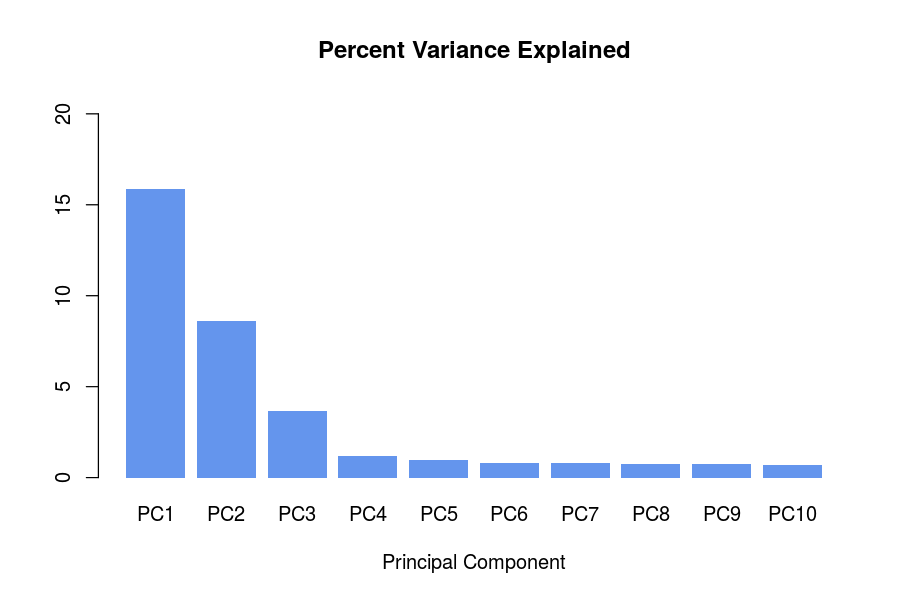

In [1]:
load("results/pca_results_all.Rdata")

#Get % variance
pca.results <- pca.results.all
dspace <- pca.results$x #transformed dataspace

#Define plot properties
options(repr.plot.width=7.5, repr.plot.height=5)

#Percent of Variance Explained for PCs 1-10
pca.var <- summary(pca.results)
barplot(pca.var$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var$importance[2,1:10]*100)+5))


Based on the truncated scree plot above, PCs 1, 2, and 3 account for most of the variance in the data, so we will look at those PCs.

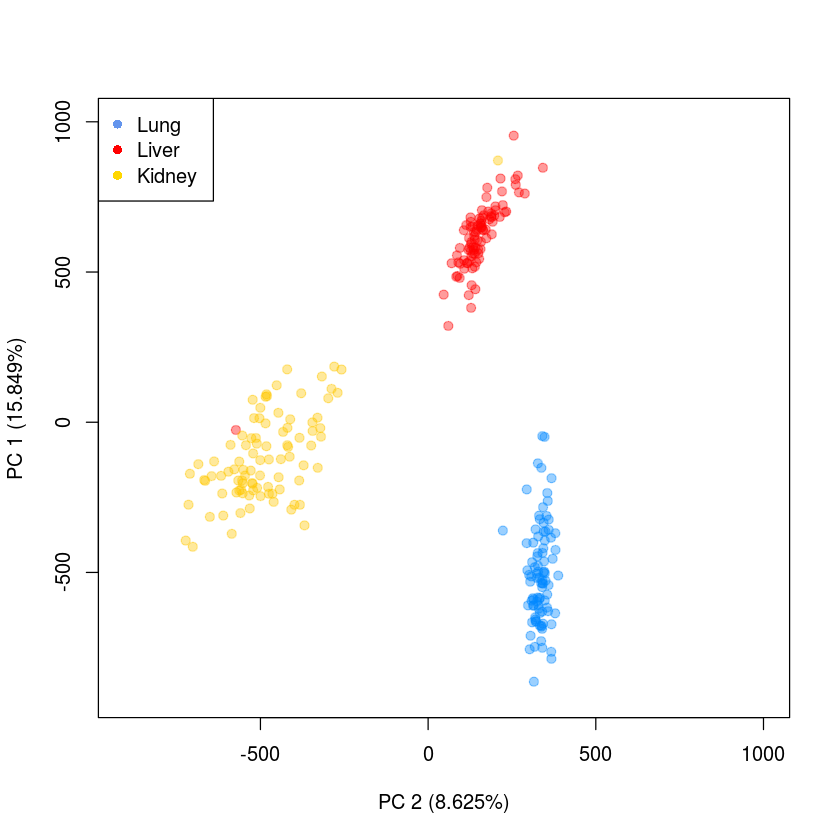

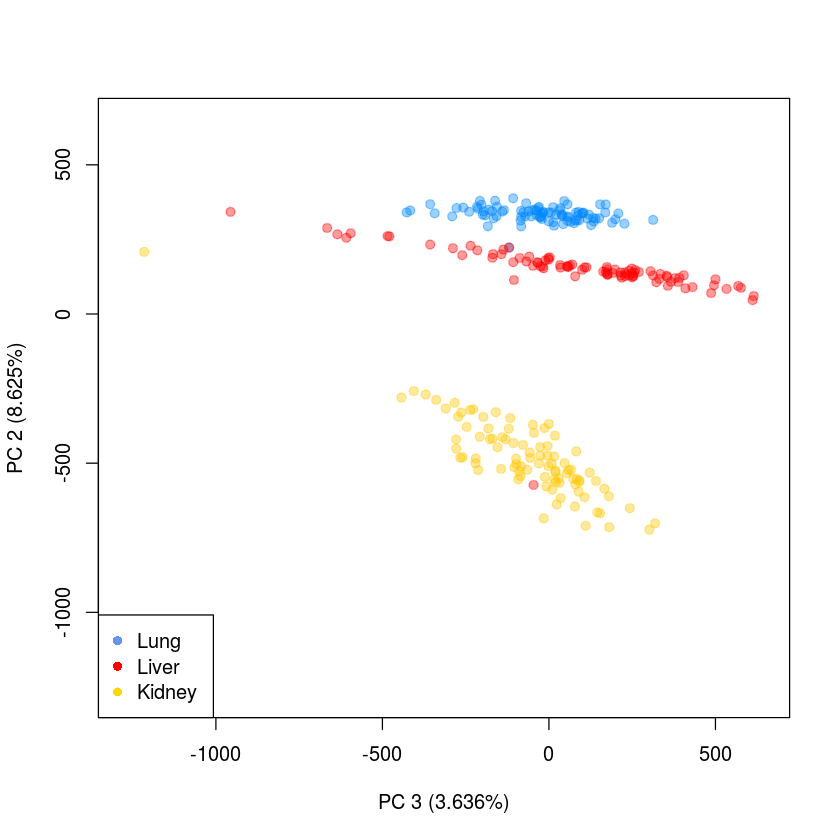

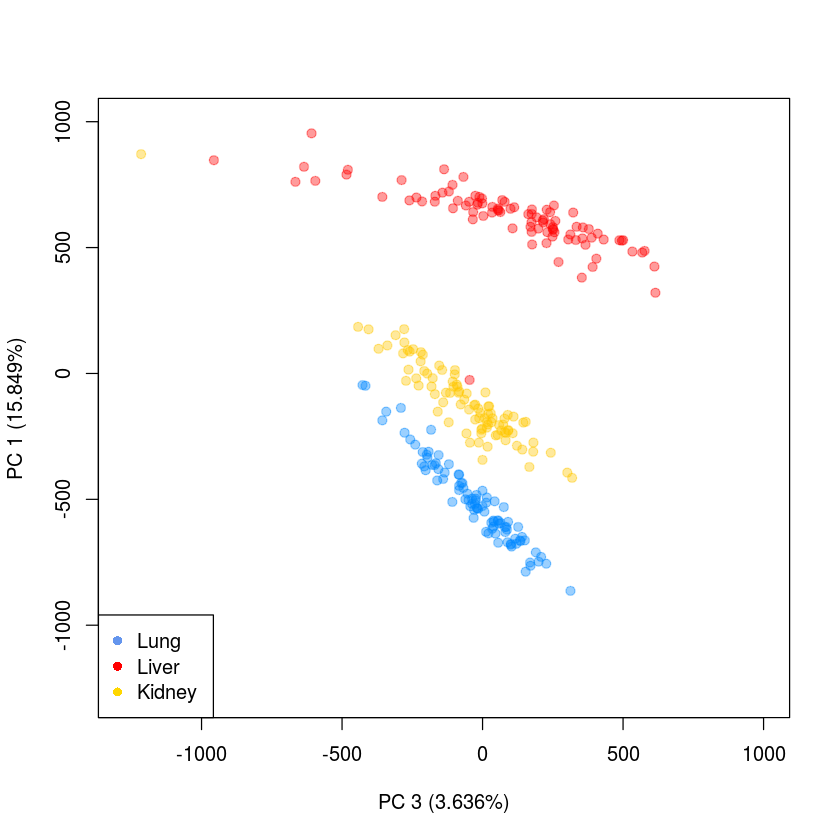

In [5]:
#Define plot properties
pc1.pov <- pca.var$importance[2,1]*100
pc2.pov <- pca.var$importance[2,2]*100
pc3.pov <- pca.var$importance[2,3]*100
options(repr.plot.width=7, repr.plot.height=7)
sample.names <- rownames(dspace)
colors <- rep(NA, length(sample.names))
lung <- grepl("LUNG", sample.names, fixed=T)
kidney <- grepl("KIDNEY", sample.names, fixed=T)
liver <- grepl("LIVER", sample.names, fixed=T)
colors[which(lung)] <- rgb(0,136,255,100, maxColorValue=255) #lightblue
colors[which(liver)] <- rgb(255,0,0,100, maxColorValue=255) #red
colors[which(kidney)] <-  rgb(255,200,0,100, maxColorValue=255) #gold
scale = 1.05
plot.lim1 = c(min(dspace[,1], dspace[,2])*scale, max(dspace[,1], dspace[,2])*scale)
plot.lim2 = c(min(dspace[,3], dspace[,2])*scale, max(dspace[,3], dspace[,2])*scale)
plot.lim3 = c(min(dspace[,3], dspace[,1])*scale, max(dspace[,3], dspace[,1])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
legend.col = c("cornflowerblue", "red", "gold")
legend.lab = c("Lung", "Liver", "Kidney")

#PC1 vs PC2
plot(y=dspace[,1], x=dspace[,2], pch=21, col=colors, bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label)
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA)

#PC2 vs PC3
plot(y=dspace[,2], x=dspace[,3], pch=21, col=colors, bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label)
legend("bottomleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA)

#PC1 vs PC3
plot(y=dspace[,1], x=dspace[,3], pch=21, col=colors, bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc1.label, xlab=pc3.label)
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA)

The above PCA plots show that in general, tissue specific chromatin accessibility generate the most variability between samples, with two exceptions. We dig deeper into these exceptions in the next section.

### Which samples are not clustering as expected?

Two of the samples are not clustering by tissue. To investigate this, we apply density-based clustering on PCs 1 and 2 using `dbscan` to identify the data points that don't lie in their expected subspaces.

Samples with tissue type discrepancies: 
CC018_Control_LIVER_ATAC_81
CC051_Control_KIDNEY_ATAC_26


[,1]                         [,2]         [,3]          
[1,] Sample                       Tissue Label Tissue Cluster
[2,] CC018_Control_LIVER_ATAC_81  LIVER        KIDNEY        
[3,] CC051_Control_KIDNEY_ATAC_26 KIDNEY       LIVER

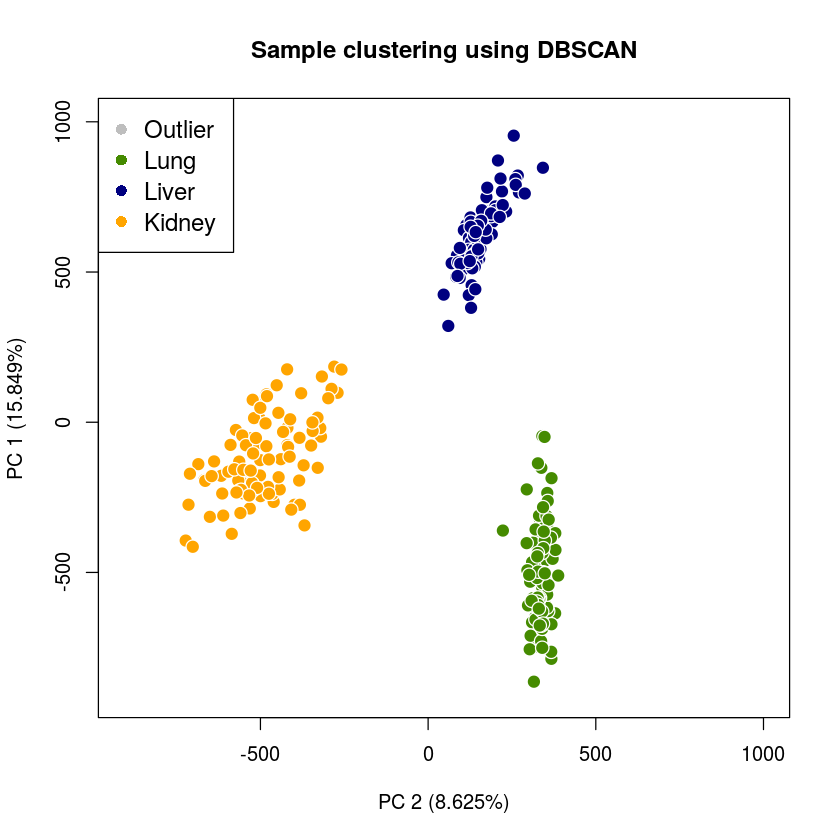

In [28]:
library(dbscan)
cluster = dbscan(x=dspace[,1:2],eps=150)$cluster
tissue.label <- sapply(strsplit(x=sample.names, split="_", fixed=T), function(x){x[3]})
tissue.cluster = as.vector(factor(cluster, levels=c(0,1,2,3), labels=c("OUTLIER", "KIDNEY", "LIVER", "LUNG")))
colors = as.vector(factor(cluster, levels=c(0,1,2,3), labels=c("gray", "orange", "navy", "chartreuse4")))
plot(y=dspace[,1], x=dspace[,2], pch=21, col="white", cex=1.5, bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     main="Sample clustering using DBSCAN")
legend("topleft", 
       legend=c("Outlier", "Lung", "Liver", "Kidney"), 
       col=c("gray", "chartreuse4", "navy", "orange"), 
       pch=16,
       cex=1.2,
       bg=NA)

cat("Samples with tissue type discrepancies: ", 
    sample.names[which(tissue.label!=tissue.cluster)], 
    sep="\n")

rbind(c("Sample","Tissue Label", "Tissue Cluster"), 
      cbind(sample.names[which(tissue.label!=tissue.cluster)],
            tissue.label[which(tissue.label!=tissue.cluster)],
            tissue.cluster[which(tissue.label!=tissue.cluster)]))


From the clustering, we see that there are clear tissue-specific clusters. We find that `CC018_Control_LIVER_ATAC_81` and `CC051_Control_KIDNEY_ATAC_26` are not falling into the correct tissue cluster. The former was not re-sequenced, but the latter is a sample that was resequenced. After looking more into these samples, I discovered that `CC018_Control_LIVER_ATAC_81` was not submitted for re-sequencing, and it was originally a problematic sample. `CC051_Control_KIDNEY_ATAC_26` was also problematic previously and clustering with the liver group, so it is possible that the original sample used for library prep and sequencing came from the wrong tissue. Because of this, we will drop both samples from all downstream analyses.

### Do we see a difference between exposure groups within tissue?

If there are consistent drastic trends in chromatin accessibility profile changes between treatment groups, we would expect these to be noticeable by PCA. The plots below assess this expectation.

In [50]:
load("results/pca_results_liver.Rdata")
load("results/pca_results_lung.Rdata")
load("results/pca_results_kidney.Rdata")

#Get % variance
dspace.liver <- pca.results.liver$x #transformed dataspace
dspace.lung <- pca.results.lung$x #transformed dataspace
dspace.kidney <- pca.results.kidney$x #transformed dataspace

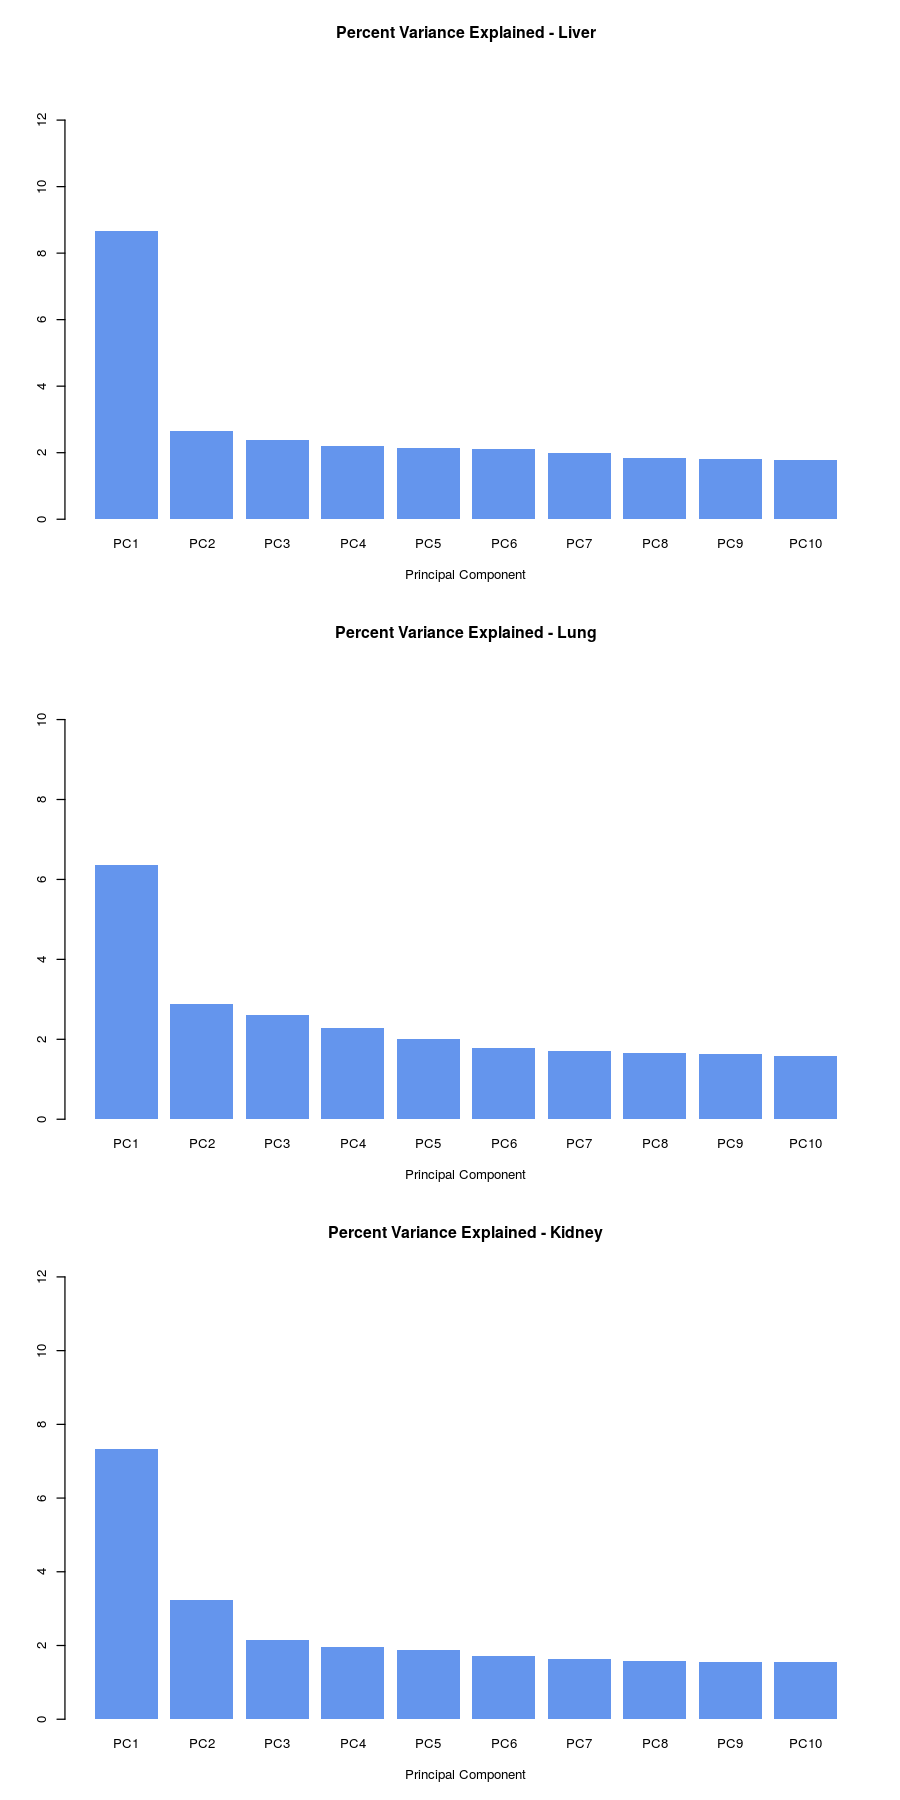

In [33]:
#Define plot properties
options(repr.plot.width=7.5, repr.plot.height=15)

#Percent of Variance Explained for PCs 1-10
par(mfrow=c(3,1))
pca.var.liver <- summary(pca.results.liver)
pca.var.lung <- summary(pca.results.lung)
pca.var.kidney <- summary(pca.results.kidney)
barplot(pca.var.liver$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained - Liver", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var.liver$importance[2,1:10]*100)+5))
barplot(pca.var.lung$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained - Lung", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var.lung$importance[2,1:10]*100)+5))
barplot(pca.var.kidney$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained - Kidney", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var.kidney$importance[2,1:10]*100)+5))

In the truncated scree plots above, the reduction in variance explained with each additional PC is not as drastic as in previous analyses, so we will explore up to PC5.

PC2 Outlier Samples:
CC018_Control_LIVER_ATAC_81
CC037_BD625_LIVER_ATAC_43

PC3 Outlier Samples:
CC061_BD625_LIVER_ATAC_122
CC061_Control_LIVER_ATAC_90


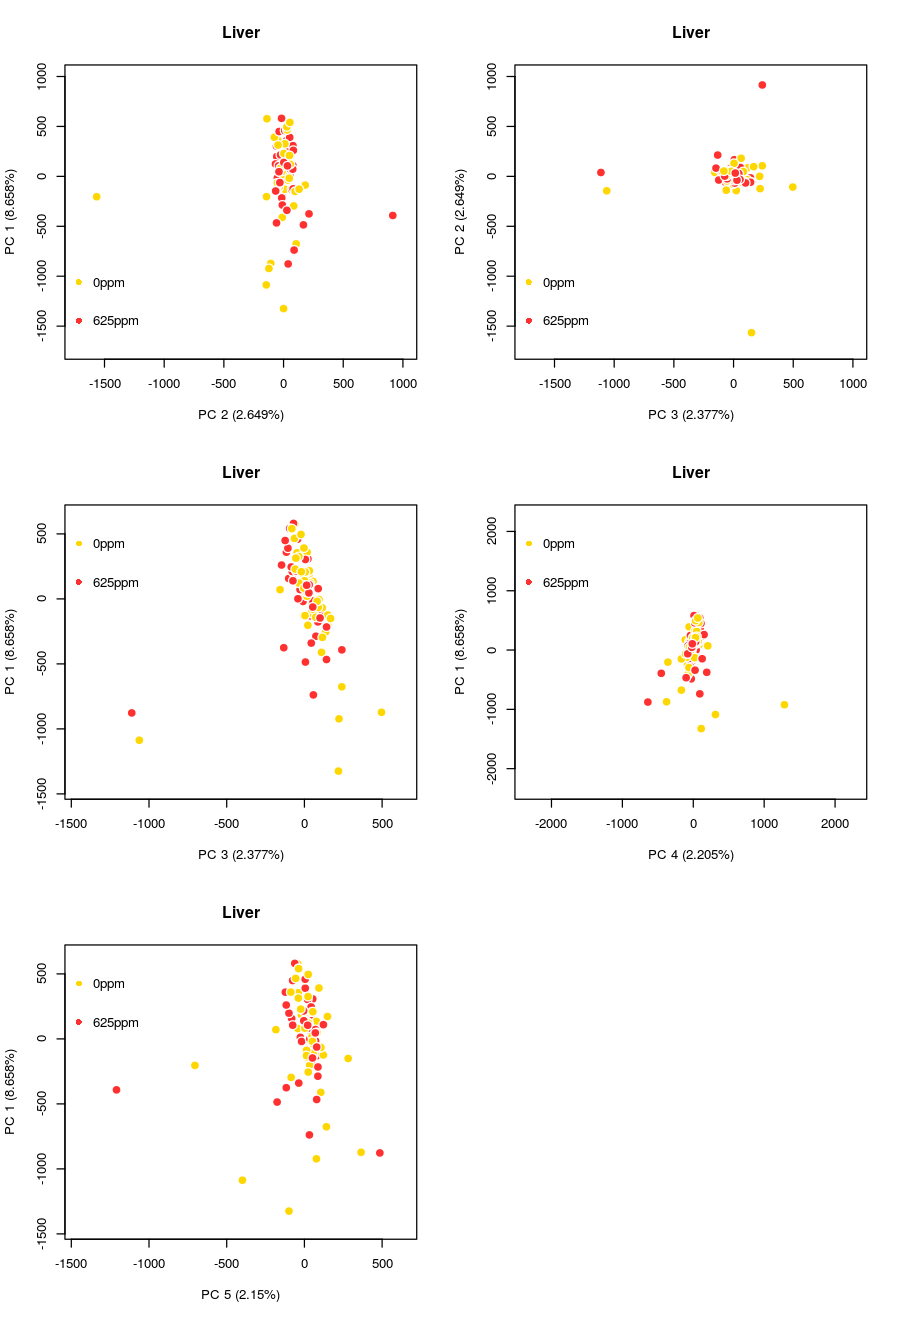

In [63]:
#PCA plots for liver tissue

#Define plot properties
pc1.pov <- pca.var.liver$importance[2,1]*100
pc2.pov <- pca.var.liver$importance[2,2]*100
pc3.pov <- pca.var.liver$importance[2,3]*100
pc4.pov <- pca.var.liver$importance[2,4]*100
pc5.pov <- pca.var.liver$importance[2,5]*100
options(repr.plot.width=7.5, repr.plot.height=11)
sample.names <- rownames(dspace.liver)
colors <- rep(NA, length(sample.names))
colors[grepl("Control", sample.names, fixed=T)] <- "gold"
colors[grepl("BD625", sample.names, fixed=T)] <- "firebrick1"
scale = 1.1
plot.lim1 = c(min(dspace.liver[,1], dspace.liver[,2])*scale, max(dspace.liver[,1], dspace.liver[,2])*scale)
plot.lim2 = c(min(dspace.liver[,3], dspace.liver[,2])*scale, max(dspace.liver[,3], dspace.liver[,2])*scale)
plot.lim3 = c(min(dspace.liver[,1], dspace.liver[,3])*scale, max(dspace.liver[,1], dspace.liver[,3])*scale)
plot.lim4 = c(min(dspace.liver[,1], dspace.liver[,4])*scale*1.6, max(dspace.liver[,1], dspace.liver[,4])*scale*1.6)
plot.lim5 = c(min(dspace.liver[,1], dspace.liver[,5])*scale, max(dspace.liver[,1], dspace.liver[,5])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
pc4.label = paste("PC 4 (",pc4.pov,"%)",sep="")
pc5.label = paste("PC 5 (",pc5.pov,"%)",sep="")
legend.col = c("gold", "firebrick1")
legend.lab = c("0ppm", "625ppm")

par(mfrow=c(3,2))
#PC1 vs PC2
plot(y=dspace.liver[,1], x=dspace.liver[,2], pch=21, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     cex=1.5, 
     main="Liver")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC3
plot(y=dspace.liver[,2], x=dspace.liver[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label,
     cex=1.5, 
     main="Liver")
legend("bottomleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA, bty="n")

#PC1 vs PC3
plot(y=dspace.liver[,1], x=dspace.liver[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc1.label, xlab=pc3.label,
     cex=1.5, 
     main="Liver")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC1 vs PC4
plot(y=dspace.liver[,1], x=dspace.liver[,4], pch=21, col="white", bg=colors, 
     xlim=plot.lim4, ylim=plot.lim4, 
     ylab=pc1.label, xlab=pc4.label,
     cex=1.5, 
     main="Liver")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC1 vs PC5
plot(y=dspace.liver[,1], x=dspace.liver[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim5, ylim=plot.lim5, 
     ylab=pc1.label, xlab=pc5.label,
     cex=1.5, 
     main="Liver")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

cat("PC2 Outlier Samples:", sample.names[which((dspace.liver[,2]>500) | (dspace.liver[,2]<(-500)))], sep="\n")
cat("\nPC3 Outlier Samples:", sample.names[which(dspace.liver[,3]<(-500))], sep="\n")

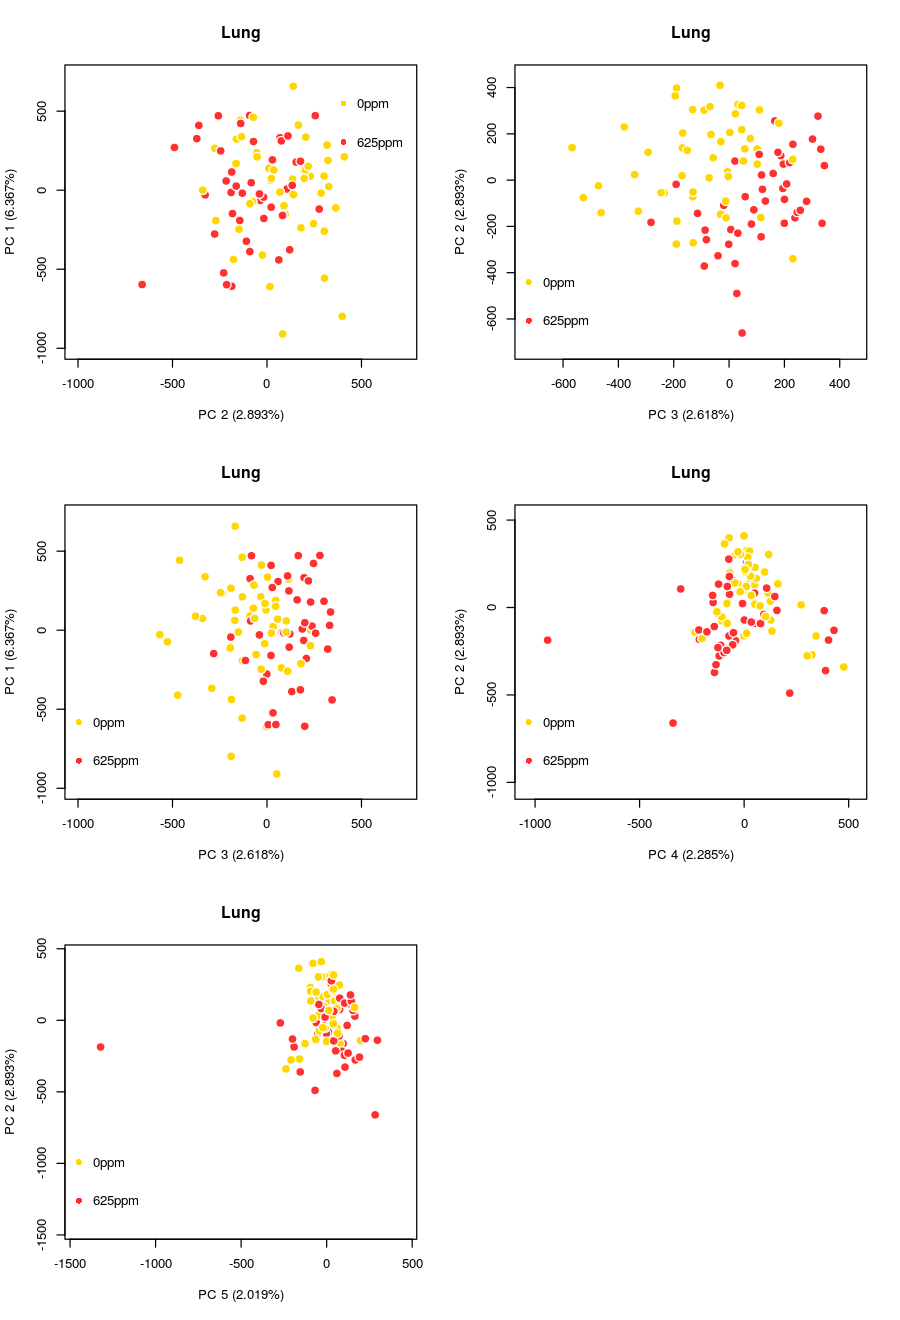

In [64]:
#PCA plots for lung tissue

#Define plot properties
pc1.pov <- pca.var.lung$importance[2,1]*100
pc2.pov <- pca.var.lung$importance[2,2]*100
pc3.pov <- pca.var.lung$importance[2,3]*100
pc4.pov <- pca.var.lung$importance[2,4]*100
pc5.pov <- pca.var.lung$importance[2,5]*100
options(repr.plot.width=7.5, repr.plot.height=11)
sample.names <- rownames(dspace.lung)
colors <- rep(NA, length(sample.names))
colors[grepl("Control", sample.names, fixed=T)] <- "gold"
colors[grepl("BD625", sample.names, fixed=T)] <- "firebrick1"
scale = 1.1
plot.lim1 = c(min(dspace.lung[,1], dspace.lung[,2])*scale, max(dspace.lung[,1], dspace.lung[,2])*scale)
plot.lim2 = c(min(dspace.lung[,3], dspace.lung[,2])*scale, max(dspace.lung[,3], dspace.lung[,2])*scale)
plot.lim3 = c(min(dspace.lung[,1], dspace.lung[,3])*scale, max(dspace.lung[,1], dspace.lung[,3])*scale)
plot.lim4 = c(min(dspace.lung[,2], dspace.lung[,4])*scale, max(dspace.lung[,2], dspace.lung[,4])*scale)
plot.lim5 = c(min(dspace.lung[,2], dspace.lung[,5])*scale, max(dspace.lung[,2], dspace.lung[,5])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
pc4.label = paste("PC 4 (",pc4.pov,"%)",sep="")
pc5.label = paste("PC 5 (",pc5.pov,"%)",sep="")
legend.col = c("gold", "firebrick1")
legend.lab = c("0ppm", "625ppm")

par(mfrow=c(3,2))
#PC1 vs PC2
plot(y=dspace.lung[,1], x=dspace.lung[,2], pch=21, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     cex=1.5,
     main="Lung")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC3
plot(y=dspace.lung[,2], x=dspace.lung[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label,
     cex=1.5,
     main="Lung")
legend("bottomleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA, bty="n")

#PC1 vs PC3
plot(y=dspace.lung[,1], x=dspace.lung[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc1.label, xlab=pc3.label,
     cex=1.5,
     main="Lung")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC4
plot(y=dspace.lung[,2], x=dspace.lung[,4], pch=21, col="white", bg=colors, 
     xlim=plot.lim4, ylim=plot.lim4, 
     ylab=pc2.label, xlab=pc4.label,
     cex=1.5,
     main="Lung")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC5
plot(y=dspace.lung[,2], x=dspace.lung[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim5, ylim=plot.lim5, 
     ylab=pc2.label, xlab=pc5.label,
     cex=1.5,
     main="Lung")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")



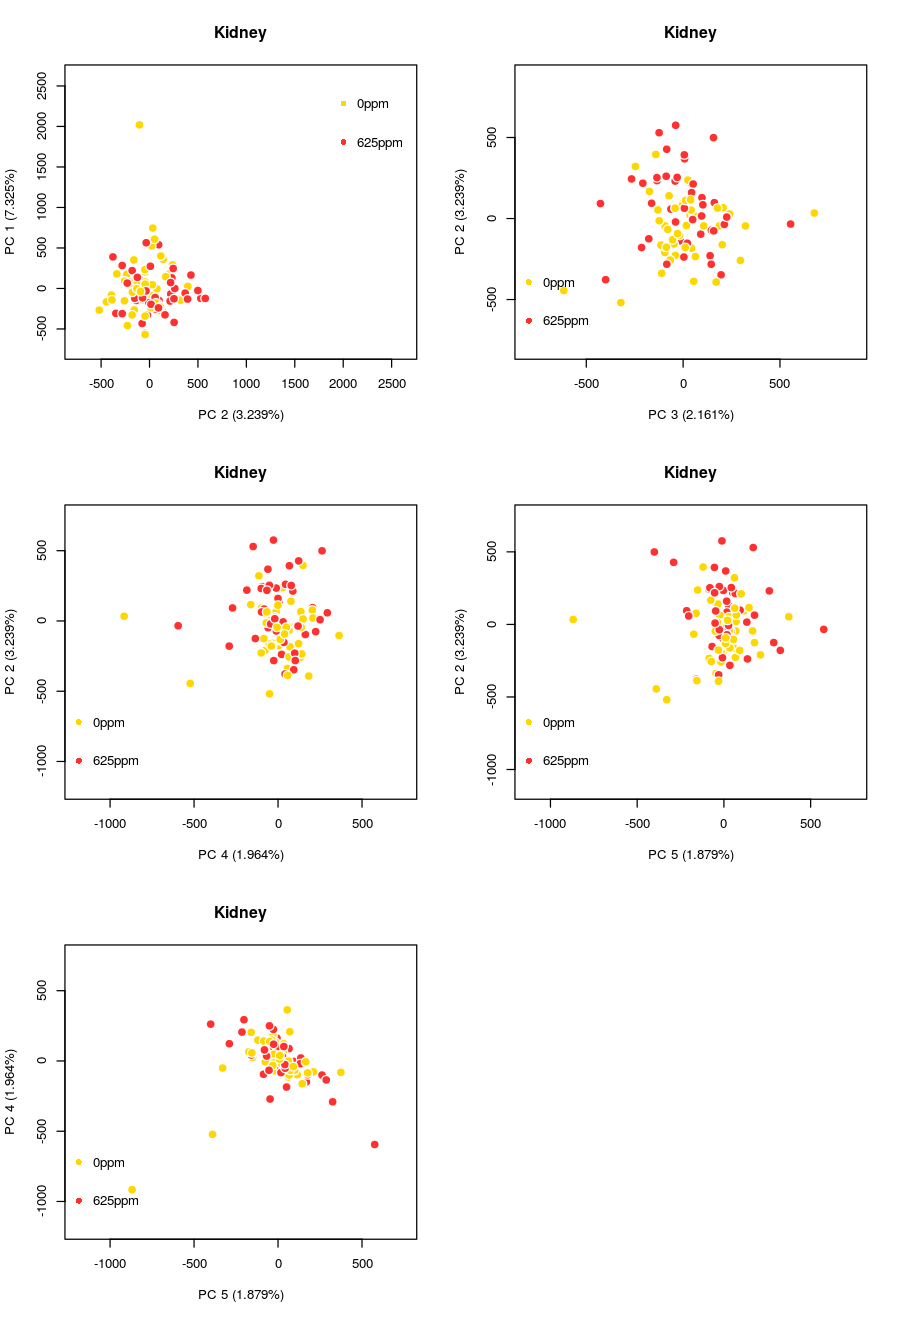

In [66]:
#PCA plots for kidney tissue

#Define plot properties
pc1.pov <- pca.var.kidney$importance[2,1]*100
pc2.pov <- pca.var.kidney$importance[2,2]*100
pc3.pov <- pca.var.kidney$importance[2,3]*100
pc4.pov <- pca.var.kidney$importance[2,4]*100
pc5.pov <- pca.var.kidney$importance[2,5]*100
options(repr.plot.width=7.5, repr.plot.height=11)
sample.names <- rownames(dspace.kidney)
colors <- rep(NA, length(sample.names))
colors[grepl("Control", sample.names, fixed=T)] <- "gold"
colors[grepl("BD625", sample.names, fixed=T)] <- "firebrick1"
scale = 1.3
plot.lim1 = c(min(dspace.kidney[,1], dspace.kidney[,2])*scale, max(dspace.kidney[,1], dspace.kidney[,2])*scale)
plot.lim2 = c(min(dspace.kidney[,3], dspace.kidney[,2])*scale, max(dspace.kidney[,3], dspace.kidney[,2])*scale)
plot.lim3 = c(min(dspace.kidney[,2], dspace.kidney[,4])*scale, max(dspace.kidney[,2], dspace.kidney[,4])*scale)
plot.lim4 = c(min(dspace.kidney[,2], dspace.kidney[,5])*scale, max(dspace.kidney[,2], dspace.kidney[,5])*scale)
plot.lim5 = c(min(dspace.kidney[,4], dspace.kidney[,5])*scale, max(dspace.kidney[,4], dspace.kidney[,5])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
pc4.label = paste("PC 4 (",pc4.pov,"%)",sep="")
pc5.label = paste("PC 5 (",pc5.pov,"%)",sep="")
legend.col = c("gold", "firebrick1")
legend.lab = c("0ppm", "625ppm")

par(mfrow=c(3,2))
#PC1 vs PC2
plot(y=dspace.kidney[,1], x=dspace.kidney[,2], pch=21, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     cex=1.5,
     main="Kidney")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC3
plot(y=dspace.kidney[,2], x=dspace.kidney[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label,
     cex=1.5,
     main="Kidney")
legend("bottomleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA, bty="n")

#PC2 vs PC4
plot(y=dspace.kidney[,2], x=dspace.kidney[,4], pch=21, col="white", bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc2.label, xlab=pc4.label,
     cex=1.5,
     main="Kidney")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC5
plot(y=dspace.kidney[,2], x=dspace.kidney[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim4, ylim=plot.lim4, 
     ylab=pc2.label, xlab=pc5.label,
     cex=1.5,
     main="Kidney")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC4 vs PC5
plot(y=dspace.kidney[,4], x=dspace.kidney[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim5, ylim=plot.lim5, 
     ylab=pc4.label, xlab=pc5.label,
     cex=1.5,
     main="Kidney")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")
